In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# For advanced vectorization methods
try:
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument
    from gensim.models import Word2Vec
    from transformers import AutoTokenizer, AutoModel
    import torch
    ADVANCED_LIBRARIES_AVAILABLE = True
except ImportError:
    ADVANCED_LIBRARIES_AVAILABLE = False
    print("Advanced libraries (gensim, transformers) not available. Will use basic vectorization methods.")

# Wordcloud
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print("WordCloud library not available.")

print("Libraries imported successfully!")
print(f"Advanced libraries available: {ADVANCED_LIBRARIES_AVAILABLE}")
print(f"WordCloud available: {WORDCLOUD_AVAILABLE}")

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('data/textual_dataset.csv')
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Libraries imported successfully!
Advanced libraries available: True
WordCloud available: True
Dataset loaded successfully!
Dataset shape: (4097, 6)

First few rows:
                                    ecole           auteur        date  note  \
0  Etablissement Ecole Polytechnique 7681             Marc  24/03/2024   5.0   
1  Etablissement Ecole Polytechnique 7681      Louis-Marie  01/12/2023   5.0   
2  Etablissement Ecole Polytechnique 7681          Batiste  23/06/2023   5.0   
3  Etablissement Ecole Polytechnique 7681          Vincent  01/03/2021   4.0   
4  Etablissement Ecole Polytechnique 7681  Jean-Tiago Hamm  15/05/2020   5.0   

                                             contenu  \
0  INCROYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
1                        La meilleure école du monde   
2    très bien, un petit peu tunnelisant nonobstant.   
3  Superbe école offrant des opportunitées incroy...   
4                 Exceptionnel à tous points de vue.   

                 

Dataset shape: (4097, 6)
Number of samples: 4097
Number of features: 6

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ecole    4097 non-null   object 
 1   auteur   4097 non-null   object 
 2   date     4097 non-null   object 
 3   note     4096 non-null   float64
 4   contenu  4096 non-null   object 
 5   url      4097 non-null   object 
dtypes: float64(1), object(5)
memory usage: 192.2+ KB
None

Column names and types:
- ecole: object
- auteur: object
- date: object
- note: float64
- contenu: object
- url: object

2. MISSING VALUES ANALYSIS
         Missing_Count  Missing_Percentage
note                 1            0.024408
contenu              1            0.024408
ecole                0            0.000000
auteur               0            0.000000
date                 0            0.000000
url                  0            0.00

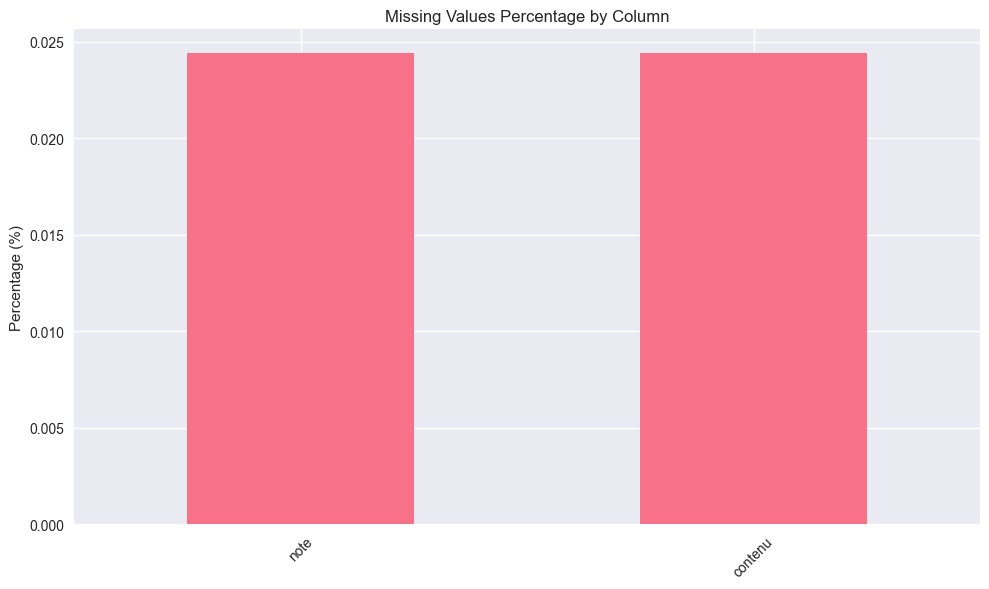


3. NUMERICAL FEATURES ANALYSIS

Numerical columns summary:
Numerical columns: ['note']
              note
count  4096.000000
mean      4.360840
std       0.922541
min       0.500000
25%       4.000000
50%       4.800000
75%       5.000000
max       5.000000

4. TARGET VARIABLE ANALYSIS (Rating)
Rating statistics:
count    4096.000000
mean        4.360840
std         0.922541
min         0.500000
25%         4.000000
50%         4.800000
75%         5.000000
max         5.000000
Name: note, dtype: float64

Rating value counts:
note
0.5       1
0.8       3
1.0      62
1.3      25
1.5      35
1.8      25
2.0      51
2.3      45
2.5      47
2.8      54
3.0      84
3.3      87
3.5     103
3.8     170
4.0     423
4.3     266
4.5     361
4.8     415
5.0    1839
Name: count, dtype: int64


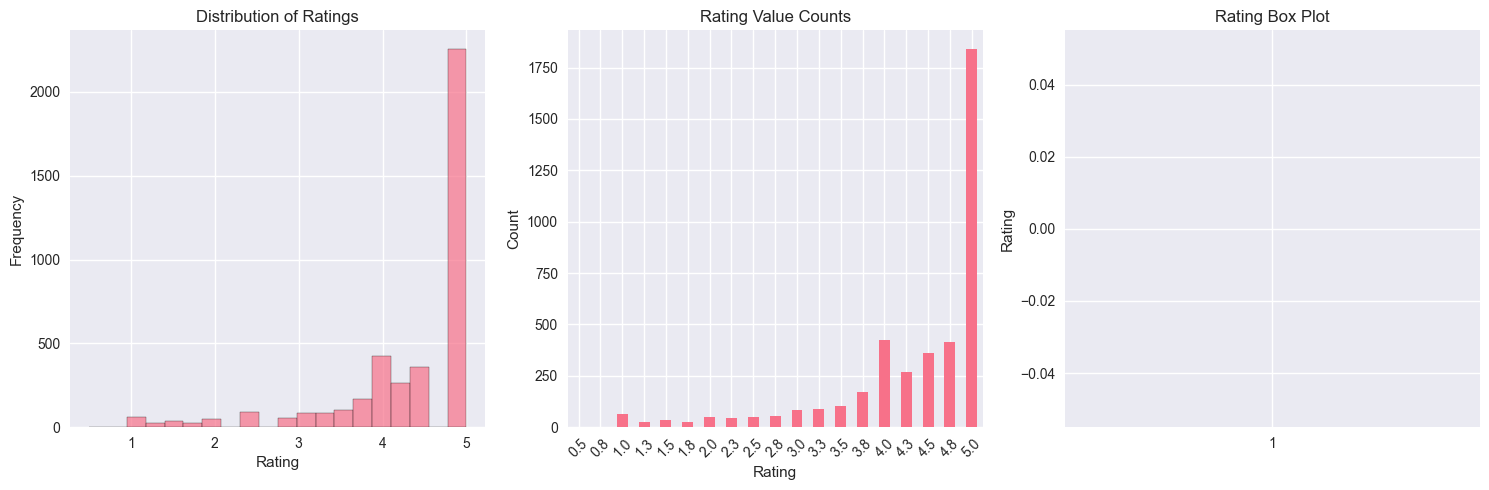


Class imbalance analysis:
Class distribution (proportions):
note
0.5    0.000244
0.8    0.000732
1.0    0.015137
1.3    0.006104
1.5    0.008545
1.8    0.006104
2.0    0.012451
2.3    0.010986
2.5    0.011475
2.8    0.013184
3.0    0.020508
3.3    0.021240
3.5    0.025146
3.8    0.041504
4.0    0.103271
4.3    0.064941
4.5    0.088135
4.8    0.101318
5.0    0.448975
Name: proportion, dtype: float64
Imbalance ratio (max/min): 1839.00
⚠️  SIGNIFICANT CLASS IMBALANCE !

5. TEXT DATA ANALYSIS
Text length statistics:
count    4097.00000
mean      212.15011
std       312.77210
min         1.00000
25%        21.00000
50%       114.00000
75%       265.00000
max      5767.00000
Name: text_length, dtype: float64

Word count statistics:
count    4097.000000
mean       32.958018
std        48.753688
min         1.000000
25%         3.000000
50%        17.000000
75%        41.000000
max       815.000000
Name: word_count, dtype: float64


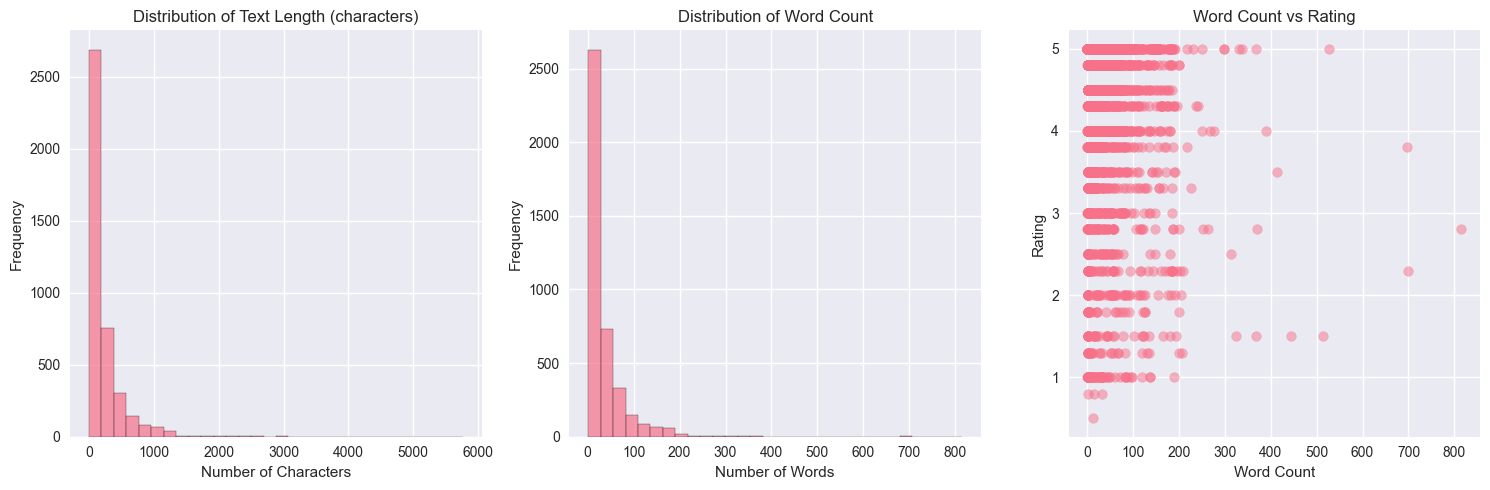

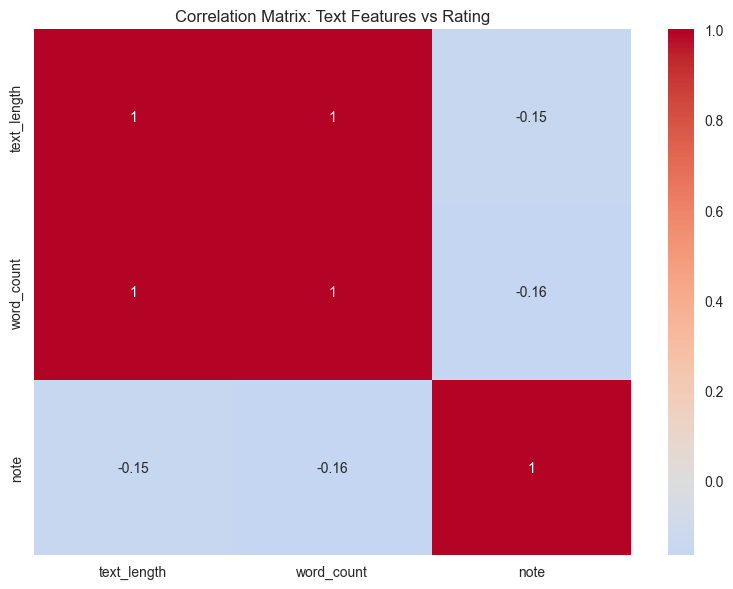


Correlations with rating:
- text_length: -0.154
- word_count: -0.164

6. SCHOOL ANALYSIS
Number of unique schools: 145

Top 10 schools by number of reviews:
ecole
Etablissement Ecole D Ingenieurs Du Cesi Centre D Orleans 81390                                  1899
Etablissement Ecole Nationale Superieure De Mecanique Et Des Microtechniques 4191                  72
Etablissement Institut Superieur D Electronique De Paris Ecole D Ingenieurs Du Numerique 6948      67
Etablissement Ecole Superieure D Ingenieurs Leonard De Vinci 7776                                  67
Etablissement Esaip Ecole D Ingenieurs 79369                                                       61
Etablissement Institut Catholique D Arts Et Metiers 5798                                           58
Etablissement Institut National Des Sciences Appliquees De Rouen Normandie 7144                    57
Etablissement Ecole D Ingenieurs De L Universite De Toulon 7452                                    55
Etablissement Instit

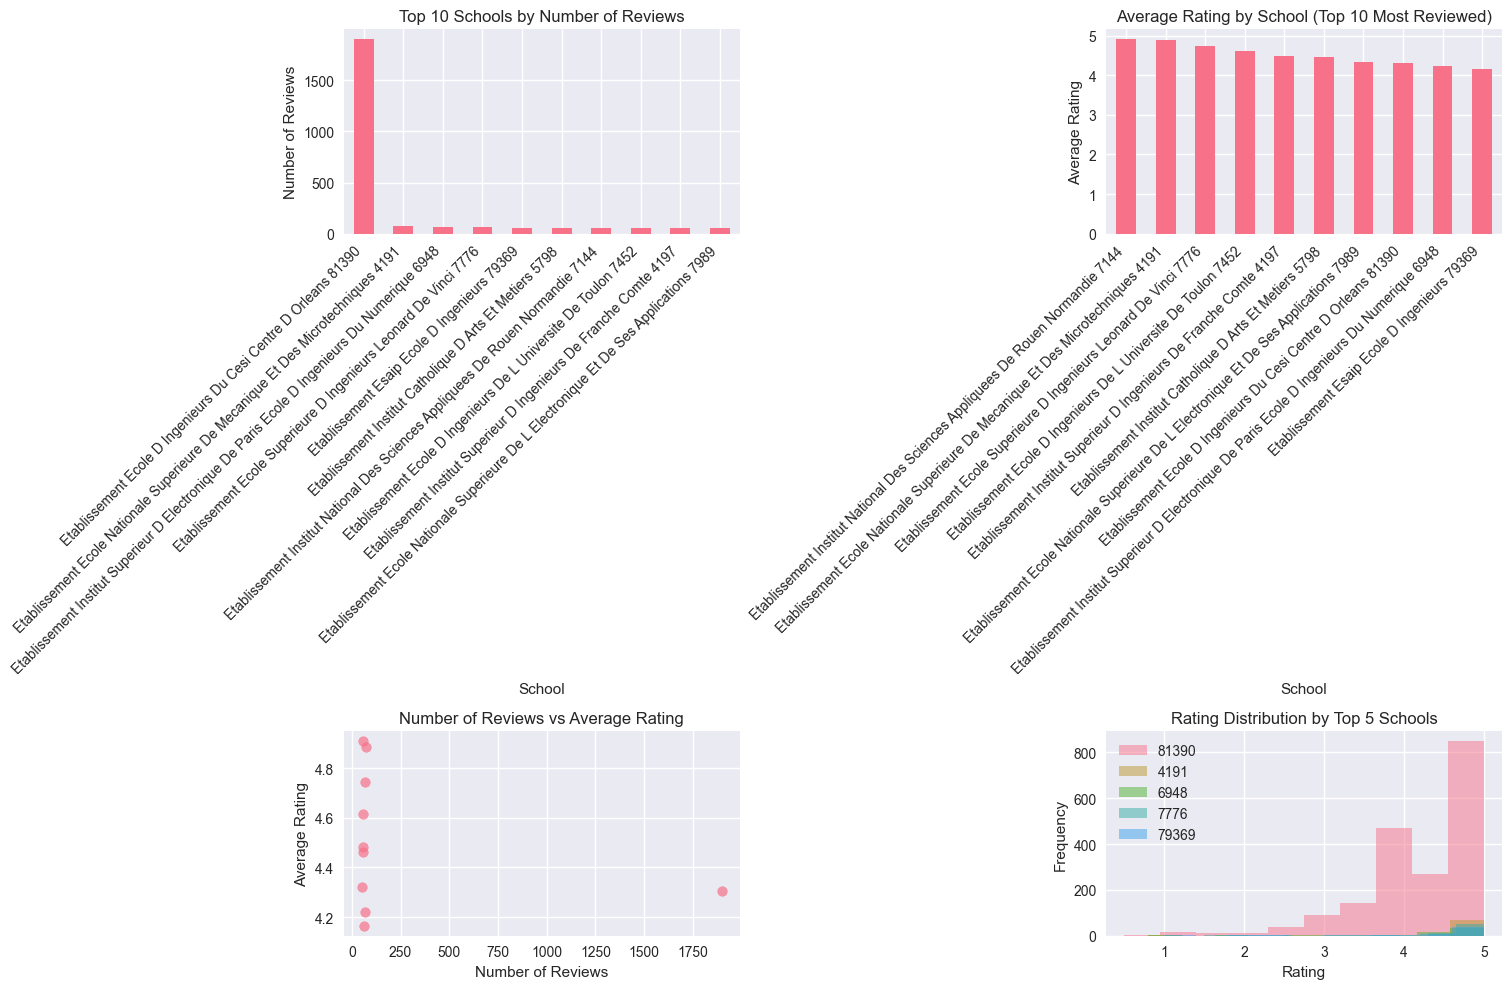

EDA COMPLETED!


In [18]:

# 1. EXPLORATORY DATA ANALYSIS (EDA)

print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")

print("\nDataset info:")
print(df.info())

print("\nColumn names and types:")
for col in df.columns:
    print(f"- {col}: {df[col].dtype}")

# Check for missing values
print("\n2. MISSING VALUES ANALYSIS")

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Count', ascending=False)

print(missing_df)

if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    missing_percentage[missing_percentage > 0].plot(kind='bar')
    plt.title('Missing Values Percentage by Column')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

# Dataset statistics
print("\n3. NUMERICAL FEATURES ANALYSIS")

print("\nNumerical columns summary:")
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

if len(numerical_cols) > 0:
    print(df[numerical_cols].describe())

# Target variable analysis (rating)
print("\n4. TARGET VARIABLE ANALYSIS (Rating)")

if 'note' in df.columns:
    print(f"Rating statistics:")
    print(df['note'].describe())
    
    print(f"\nRating value counts:")
    rating_counts = df['note'].value_counts().sort_index()
    print(rating_counts)
    
    # Visualize rating distribution
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df['note'], bins=20, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    rating_counts.plot(kind='bar')
    plt.title('Rating Value Counts')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 3)
    plt.boxplot(df['note'])
    plt.title('Rating Box Plot')
    plt.ylabel('Rating')
    
    plt.tight_layout()
    plt.show()
    
    # Check for class imbalance
    print(f"\nClass imbalance analysis:")
    class_distribution = df['note'].value_counts(normalize=True).sort_index()
    print("Class distribution (proportions):")
    print(class_distribution)
    
    # Calculate imbalance ratio
    max_class = class_distribution.max()
    min_class = class_distribution.min()
    imbalance_ratio = max_class / min_class
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    print("⚠️  SIGNIFICANT CLASS IMBALANCE !")


# Text data analysis
print("\n5. TEXT DATA ANALYSIS")

text_column = 'contenu'

if text_column in df.columns:
    # Text length analysis
    df['text_length'] = df[text_column].astype(str).apply(len)
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    
    print(f"Text length statistics:")
    print(df['text_length'].describe())
    
    print(f"\nWord count statistics:")
    print(df['word_count'].describe())
    
    # Visualize text statistics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(df['text_length'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Text Length (characters)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(df['word_count'], bins=30, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Word Count')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.scatter(df['word_count'], df['note'], alpha=0.5)
    plt.title('Word Count vs Rating')
    plt.xlabel('Word Count')
    plt.ylabel('Rating')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation between text features and rating
    text_features = ['text_length', 'word_count']
    correlation_matrix = df[text_features + ['note']].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix: Text Features vs Rating')
    plt.tight_layout()
    plt.show()
    
    print(f"\nCorrelations with rating:")
    for feature in text_features:
        corr = df[feature].corr(df['note'])
        print(f"- {feature}: {corr:.3f}")

# School analysis
print("\n6. SCHOOL ANALYSIS")

if 'ecole' in df.columns:
    print(f"Number of unique schools: {df['ecole'].nunique()}")
    print(f"\nTop 10 schools by number of reviews:")
    school_counts = df['ecole'].value_counts().head(10)
    print(school_counts)
    
    # Average rating by school (top 10 most reviewed)
    top_schools = school_counts.index[:10]
    school_ratings = df[df['ecole'].isin(top_schools)].groupby('ecole')['note'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    
    print(f"\nAverage ratings for top 10 most reviewed schools:")
    print(school_ratings)
    
    # Visualize school statistics
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    school_counts.plot(kind='bar')
    plt.title('Top 10 Schools by Number of Reviews')
    plt.xlabel('School')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(2, 2, 2)
    school_ratings['mean'].plot(kind='bar')
    plt.title('Average Rating by School (Top 10 Most Reviewed)')
    plt.xlabel('School')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(2, 2, 3)
    plt.scatter(school_ratings['count'], school_ratings['mean'], alpha=0.7)
    plt.title('Number of Reviews vs Average Rating')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Average Rating')
    
    plt.subplot(2, 2, 4)
    # Rating distribution by top schools
    top_5_schools = school_counts.index[:5]
    for school in top_5_schools:
        school_data = df[df['ecole'] == school]['note']
        plt.hist(school_data, alpha=0.5, label=school.split()[-1][:10], bins=10)
    plt.title('Rating Distribution by Top 5 Schools')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


print("EDA COMPLETED!")


1. APPLYING TEXT PREPROCESSING
Text preprocessing completed!

Example of preprocessing:
Original: INCROYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
Cleaned:  incroyaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
Stemmed:  incroyaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...

2. GENERATING WORD CLOUDS
Text preprocessing completed!

Example of preprocessing:
Original: INCROYAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
Cleaned:  incroyaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
Stemmed:  incroyaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...

2. GENERATING WORD CLOUDS


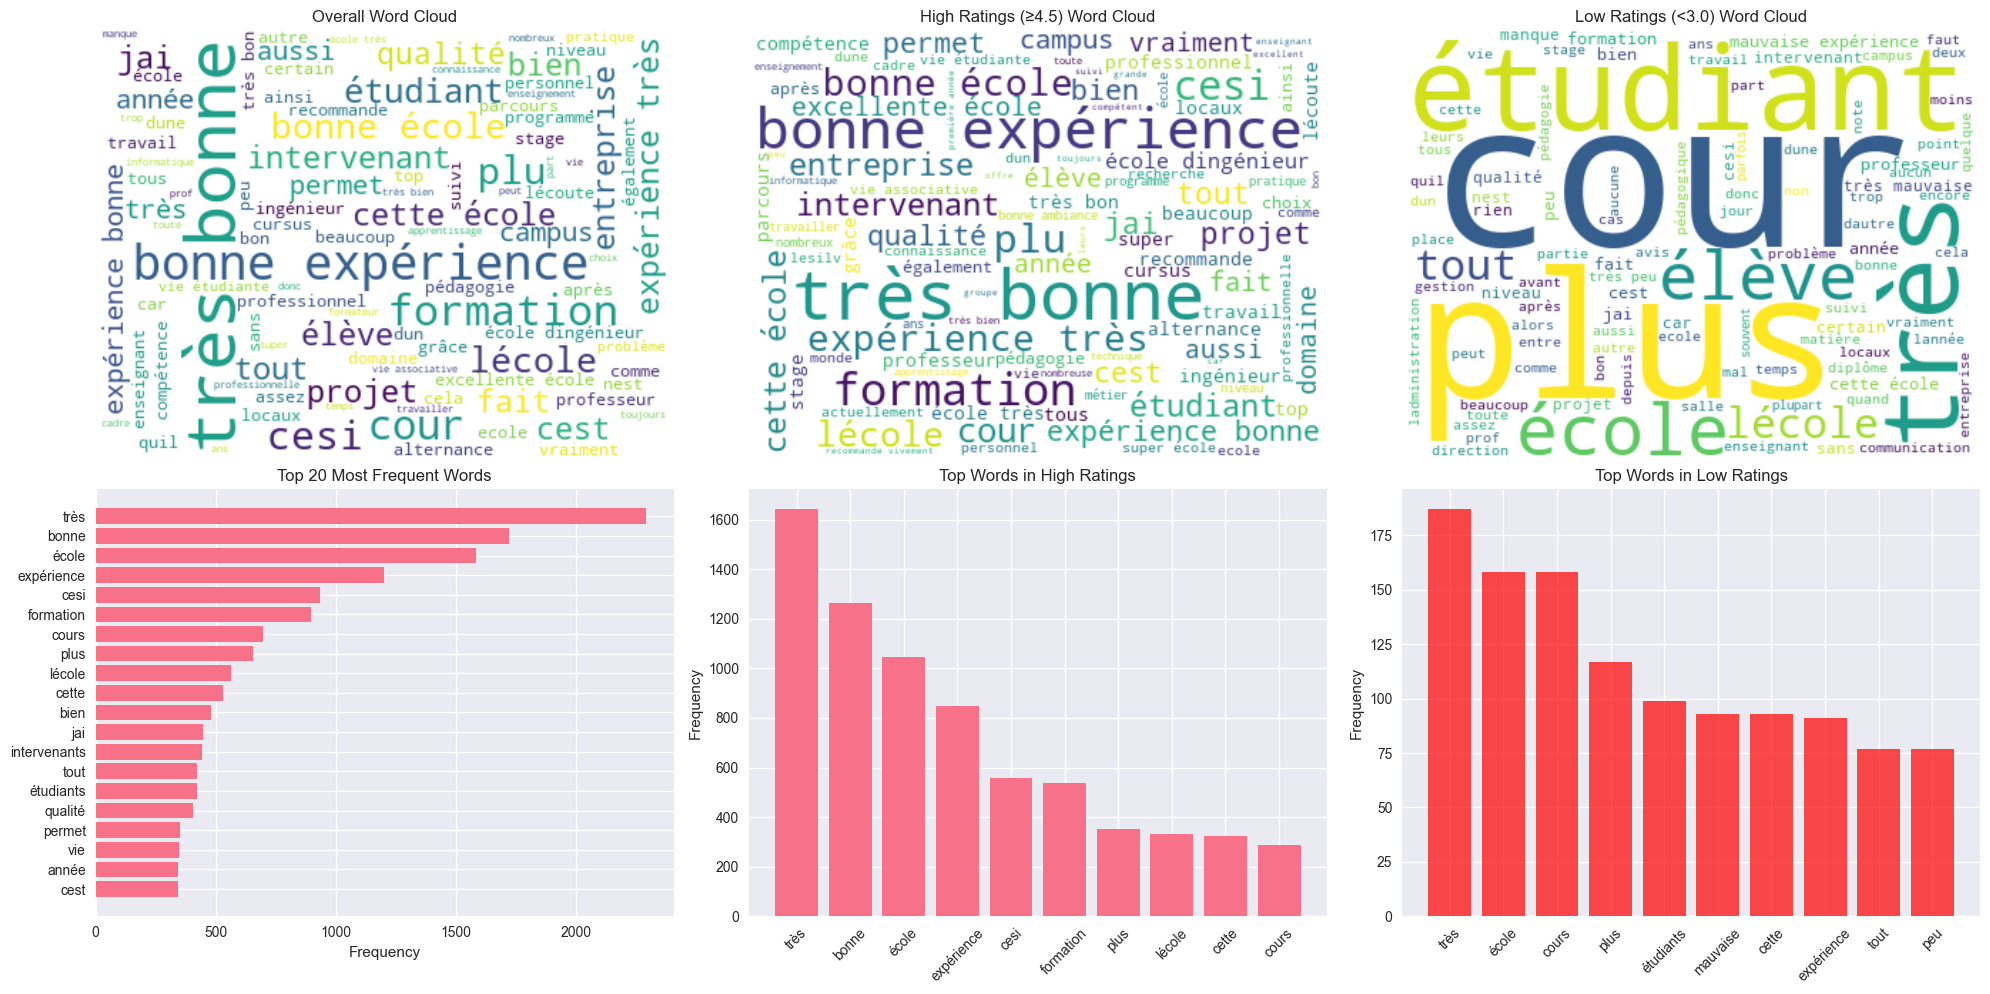

Word clouds generated successfully!

Word frequency statistics:
Total unique words: 10756
Most common words: [('très', 2291), ('bonne', 1721), ('école', 1585), ('expérience', 1201), ('cesi', 936), ('formation', 895), ('cours', 695), ('plus', 657), ('lécole', 564), ('cette', 529)]


In [19]:
# 2. TEXT PREPROCESSING AND WORD CLOUDS

# Define French text preprocessing function
def preprocess_french_text(text, remove_stopwords=True, stemming=False):
    """
    Preprocess French text for analysis
    """
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    try:
        tokens = word_tokenize(text, language='french')
    except:
        tokens = text.split()
    
    # Remove stopwords if requested
    if remove_stopwords:
        try:
            french_stopwords = set(stopwords.words('french'))
            # Add some common French words that might not be in the standard list
            french_stopwords.update(['être', 'avoir', 'faire', 'dire', 'aller', 'voir', 'savoir', 'pouvoir', 'vouloir', 'venir', 'falloir', 'devoir', 'croire', 'trouver', 'donner', 'prendre'])
            tokens = [token for token in tokens if token not in french_stopwords and len(token) > 2]
        except:
            # If French stopwords not available, use basic filtering
            basic_stopwords = {'le', 'la', 'les', 'un', 'une', 'des', 'de', 'du', 'et', 'ou', 'à', 'ce', 'que', 'qui', 'dans', 'pour', 'avec', 'sur', 'par', 'est', 'sont', 'être', 'avoir'}
            tokens = [token for token in tokens if token not in basic_stopwords and len(token) > 2]
    
    # Stemming if requested
    if stemming:
        stemmer = SnowballStemmer('french')
        tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply text preprocessing
print("1. APPLYING TEXT PREPROCESSING")

df['contenu_clean'] = df['contenu'].apply(lambda x: preprocess_french_text(x, remove_stopwords=True, stemming=False))
df['contenu_stemmed'] = df['contenu'].apply(lambda x: preprocess_french_text(x, remove_stopwords=True, stemming=True))

print("Text preprocessing completed!")
print(f"\nExample of preprocessing:")
print(f"Original: {df['contenu'].iloc[0][:100]}...")
print(f"Cleaned:  {df['contenu_clean'].iloc[0][:100]}...")
print(f"Stemmed:  {df['contenu_stemmed'].iloc[0][:100]}...")

# Generate word clouds
print("\n2. GENERATING WORD CLOUDS")

if WORDCLOUD_AVAILABLE:
    # Overall word cloud
    all_text = ' '.join(df['contenu_clean'].dropna())
    
    plt.figure(figsize=(20, 10))
    
    # Overall word cloud
    plt.subplot(2, 3, 1)
    wordcloud = WordCloud(width=400, height=300, background_color='white', max_words=100).generate(all_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Overall Word Cloud')
    plt.axis('off')
    
    # Word clouds by rating categories
    # High ratings (4.5+)
    high_rating_text = ' '.join(df[df['note'] >= 4.5]['contenu_clean'].dropna())
    if high_rating_text:
        plt.subplot(2, 3, 2)
        wordcloud_high = WordCloud(width=400, height=300, background_color='white', max_words=100).generate(high_rating_text)
        plt.imshow(wordcloud_high, interpolation='bilinear')
        plt.title('High Ratings (≥4.5) Word Cloud')
        plt.axis('off')
    
    # Low ratings (<3.0)
    low_rating_text = ' '.join(df[df['note'] < 3.0]['contenu_clean'].dropna())
    if low_rating_text:
        plt.subplot(2, 3, 3)
        wordcloud_low = WordCloud(width=400, height=300, background_color='white', max_words=100).generate(low_rating_text)
        plt.imshow(wordcloud_low, interpolation='bilinear')
        plt.title('Low Ratings (<3.0) Word Cloud')
        plt.axis('off')
    
    # Most frequent words analysis
    from collections import Counter
    
    # Get all words
    all_words = []
    for text in df['contenu_clean'].dropna():
        all_words.extend(text.split())
    
    word_freq = Counter(all_words)
    most_common_words = word_freq.most_common(20)
    
    plt.subplot(2, 3, 4)
    words, counts = zip(*most_common_words)
    plt.barh(range(len(words)), counts)
    plt.yticks(range(len(words)), words)
    plt.xlabel('Frequency')
    plt.title('Top 20 Most Frequent Words')
    plt.gca().invert_yaxis()
    
    # Word frequency by rating
    high_words = []
    for text in df[df['note'] >= 4.5]['contenu_clean'].dropna():
        high_words.extend(text.split())
    
    low_words = []
    for text in df[df['note'] < 3.0]['contenu_clean'].dropna():
        low_words.extend(text.split())
    
    high_freq = Counter(high_words)
    low_freq = Counter(low_words)
    
    plt.subplot(2, 3, 5)
    high_common = dict(high_freq.most_common(10))
    plt.bar(range(len(high_common)), list(high_common.values()))
    plt.xticks(range(len(high_common)), list(high_common.keys()), rotation=45)
    plt.title('Top Words in High Ratings')
    plt.ylabel('Frequency')
    
    plt.subplot(2, 3, 6)
    low_common = dict(low_freq.most_common(10))
    plt.bar(range(len(low_common)), list(low_common.values()), color='red', alpha=0.7)
    plt.xticks(range(len(low_common)), list(low_common.keys()), rotation=45)
    plt.title('Top Words in Low Ratings')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    print("Word clouds generated successfully!")
    
    # Print word frequency statistics
    print(f"\nWord frequency statistics:")
    print(f"Total unique words: {len(word_freq)}")
    print(f"Most common words: {most_common_words[:10]}")
    
else:
    print("WordCloud library not available. Skipping word cloud generation.")
    
    # Alternative: basic word frequency analysis
    from collections import Counter
    all_words = []
    for text in df['contenu_clean'].dropna():
        all_words.extend(text.split())
    
    word_freq = Counter(all_words)
    most_common_words = word_freq.most_common(20)
    
    plt.figure(figsize=(12, 8))
    words, counts = zip(*most_common_words)
    plt.barh(range(len(words)), counts)
    plt.yticks(range(len(words)), words)
    plt.xlabel('Frequency')
    plt.title('Top 20 Most Frequent Words')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"Most common words: {most_common_words[:10]}")


1. PREPARING FEATURES
Numerical features: ['text_length', 'word_count', 'exclamation_count', 'question_count', 'capital_ratio']
Numerical features statistics:
       text_length   word_count  exclamation_count  question_count  \
count   4097.00000  4097.000000        4097.000000     4097.000000   
mean     212.15011    32.958018           0.196241        0.014401   
std      312.77210    48.753688           0.577961        0.240112   
min        1.00000     1.000000           0.000000        0.000000   
25%       21.00000     3.000000           0.000000        0.000000   
50%      114.00000    17.000000           0.000000        0.000000   
75%      265.00000    41.000000           0.000000        0.000000   
max     5767.00000   815.000000           8.000000       12.000000   

       capital_ratio  
count    4097.000000  
mean        0.035722  
std         0.049459  
min         0.000000  
25%         0.014493  
50%         0.027027  
75%         0.047619  
max         1.000000  

2.

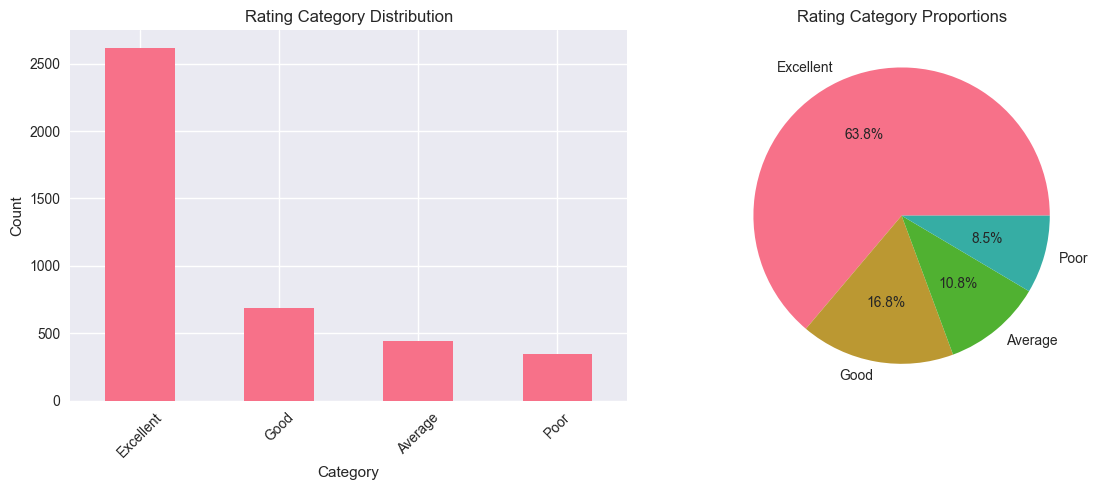

Imbalance ratio: 7.49
Needs resampling: True

3. RESAMPLING ANALYSIS
Applying resampling techniques...
Original training set distribution:
  Average: 355
  Excellent: 2092
  Good: 551
  Poor: 279

After SMOTE (oversampling):
  Average: 2092
  Excellent: 2092
  Good: 2092
  Poor: 2092

After Random Under Sampling:
  Average: 279
  Excellent: 279
  Good: 279
  Poor: 279


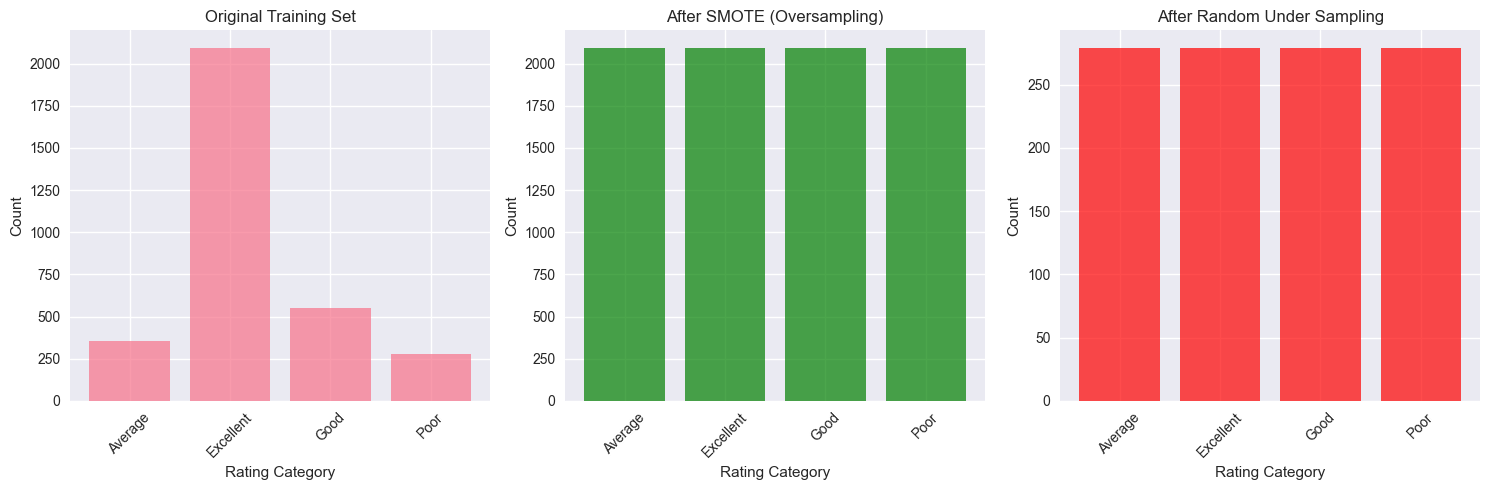


4. PCA FOR FEATURE EXTRACTION
Original feature dimensions: 5
PCA dimensions: 3
Explained variance ratio: [0.44778918 0.20193922 0.18723749]
Cumulative explained variance: [0.44778918 0.6497284  0.83696589]


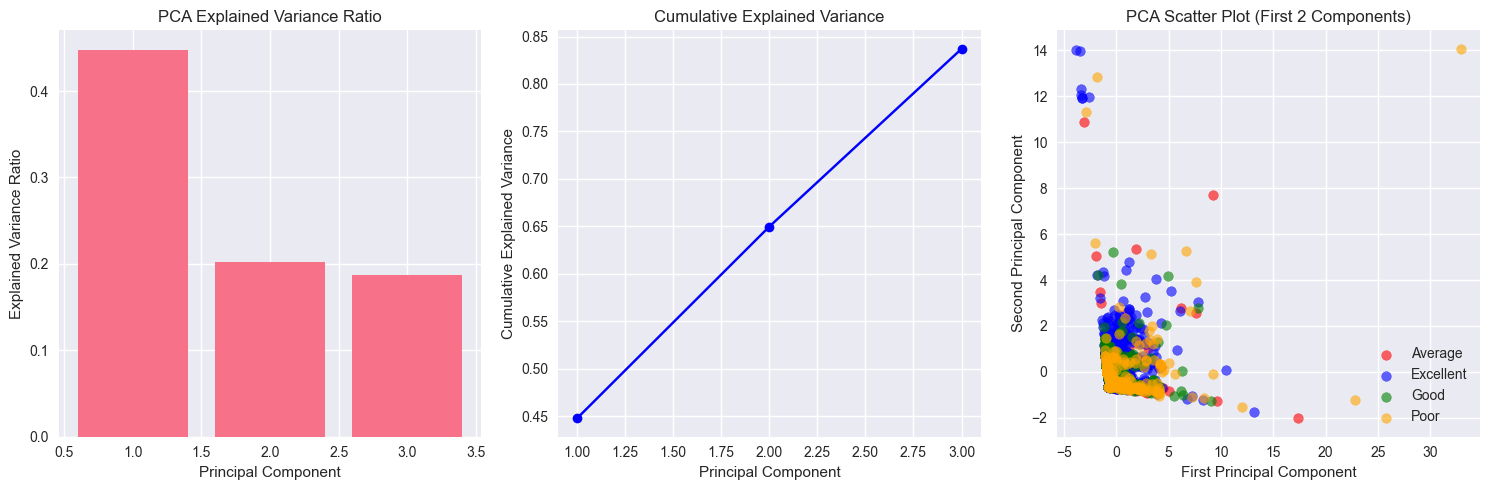


PCA Component Loadings:
                        PC1       PC2       PC3
text_length        0.641839 -0.059244 -0.116226
word_count         0.644050 -0.053590 -0.108451
exclamation_count  0.183289  0.523392  0.831892
question_count     0.336490  0.311637 -0.250429
capital_ratio     -0.162548  0.789025 -0.469010

5. PCA EFFECTIVENESS ANALYSIS
Components needed for 90% variance: 1
Components needed for 95% variance: 1
PCA is beneficial: Can reduce from 5 to 1 features while keeping 90% variance
Use PCA for modeling: True


In [20]:

# 3. RESAMPLING AND FEATURE EXTRACTION


# First, let's prepare our features for analysis
print("1. PREPARING FEATURES")


# Create numerical features
numerical_features = ['text_length', 'word_count']

# For demonstration, let's also create some additional numerical features
df['exclamation_count'] = df['contenu'].astype(str).apply(lambda x: x.count('!'))
df['question_count'] = df['contenu'].astype(str).apply(lambda x: x.count('?'))
df['capital_ratio'] = df['contenu'].astype(str).apply(lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1))

# Add these to numerical features
numerical_features.extend(['exclamation_count', 'question_count', 'capital_ratio'])

print(f"Numerical features: {numerical_features}")
print(f"Numerical features statistics:")
print(df[numerical_features].describe())

# Prepare target variable
# For classification, we'll create rating categories
def categorize_rating(rating):
    if rating >= 4.5:
        return 'Excellent'
    elif rating >= 4.0:
        return 'Good'
    elif rating >= 3.0:
        return 'Average'
    else:
        return 'Poor'

df['rating_category'] = df['note'].apply(categorize_rating)

print(f"\n2. TARGET VARIABLE PREPARATION")

print("Rating category distribution:")
category_counts = df['rating_category'].value_counts()
print(category_counts)

# Check for class imbalance
print(f"\nClass imbalance check:")
category_proportions = df['rating_category'].value_counts(normalize=True)
print("Class proportions:")
print(category_proportions)

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_counts.plot(kind='bar')
plt.title('Rating Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
category_proportions.plot(kind='pie', autopct='%1.1f%%')
plt.title('Rating Category Proportions')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Determine if resampling is needed
max_prop = category_proportions.max()
min_prop = category_proportions.min()
imbalance_ratio = max_prop / min_prop

print(f"Imbalance ratio: {imbalance_ratio:.2f}")

NEEDS_RESAMPLING = imbalance_ratio > 2.0
print(f"Needs resampling: {NEEDS_RESAMPLING}")

# 3. APPLY RESAMPLING IF NEEDED
print(f"\n3. RESAMPLING ANALYSIS")


if NEEDS_RESAMPLING:
    print("Applying resampling techniques...")
    
    # Prepare data for resampling
    X_numerical = df[numerical_features].fillna(0)
    y = df['rating_category']
    
    # Label encode the target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_numerical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"Original training set distribution:")
    unique, counts = np.unique(y_train, return_counts=True)
    for i, (label, count) in enumerate(zip(le.classes_, counts)):
        print(f"  {label}: {count}")
    
    # Apply SMOTE (oversampling)
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    print(f"\nAfter SMOTE (oversampling):")
    unique, counts = np.unique(y_train_smote, return_counts=True)
    for i, (label, count) in enumerate(zip(le.classes_, counts)):
        print(f"  {label}: {count}")
    
    # Apply Random Under Sampling
    rus = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    
    print(f"\nAfter Random Under Sampling:")
    unique, counts = np.unique(y_train_under, return_counts=True)
    for i, (label, count) in enumerate(zip(le.classes_, counts)):
        print(f"  {label}: {count}")
    
    # Visualize resampling effects
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar([le.classes_[i] for i in unique], counts, alpha=0.7)
    plt.title('Original Training Set')
    plt.xlabel('Rating Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 2)
    unique, counts = np.unique(y_train_smote, return_counts=True)
    plt.bar([le.classes_[i] for i in unique], counts, alpha=0.7, color='green')
    plt.title('After SMOTE (Oversampling)')
    plt.xlabel('Rating Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 3, 3)
    unique, counts = np.unique(y_train_under, return_counts=True)
    plt.bar([le.classes_[i] for i in unique], counts, alpha=0.7, color='red')
    plt.title('After Random Under Sampling')
    plt.xlabel('Rating Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Class distribution is relatively balanced. No resampling needed.")
    
    # Still prepare the data for modeling
    X_numerical = df[numerical_features].fillna(0)
    y = df['rating_category']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_numerical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # For consistency, create copies for different resampling strategies
    X_train_smote, y_train_smote = X_train.copy(), y_train.copy()
    X_train_under, y_train_under = X_train.copy(), y_train.copy()

# 4. PCA FOR FEATURE EXTRACTION
print(f"\n4. PCA FOR FEATURE EXTRACTION")


# Standardize features before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
n_components = min(len(numerical_features), 3)  # Keep at most 3 components for visualization
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original feature dimensions: {X_train.shape[1]}")
print(f"PCA dimensions: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

# Visualize PCA results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 3, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

# PCA scatter plot (if we have at least 2 components)
if X_train_pca.shape[1] >= 2:
    plt.subplot(1, 3, 3)
    colors = ['red', 'blue', 'green', 'orange']
    for i, category in enumerate(le.classes_):
        mask = y_train == i
        plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                   c=colors[i % len(colors)], label=category, alpha=0.6)
    plt.title('PCA Scatter Plot (First 2 Components)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()

plt.tight_layout()
plt.show()

# Print PCA component loadings
print(f"\nPCA Component Loadings:")
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=numerical_features
)
print(components_df)

# Determine if PCA is beneficial
print(f"\n5. PCA EFFECTIVENESS ANALYSIS")

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
variance_95 = np.argmax(cumulative_variance >= 0.95) + 1
variance_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Components needed for 90% variance: {variance_90}")
print(f"Components needed for 95% variance: {variance_95}")

if variance_90 < len(numerical_features):
    print(f"PCA is beneficial: Can reduce from {len(numerical_features)} to {variance_90} features while keeping 90% variance")
    USE_PCA = True
else:
    print(f"PCA not very beneficial: Original features already optimal")
    USE_PCA = False

print(f"Use PCA for modeling: {USE_PCA}")



1. PREPARING TEXT DATA FOR VECTORIZATION
Text training set size: 3277
Text test set size: 820

2. BAG OF WORDS (BoW) VECTORIZATION
BoW Features shape: (3277, 1000)
BoW Vocabulary size: 1000
BoW Top 10 features: ['absolument' 'académique' 'accessible' 'accompagne' 'accompagnement'
 'accompagné' 'accès' 'acquises' 'acquérir' 'actif']

3. TF-IDF VECTORIZATION
BoW Features shape: (3277, 1000)
BoW Vocabulary size: 1000
BoW Top 10 features: ['absolument' 'académique' 'accessible' 'accompagne' 'accompagnement'
 'accompagné' 'accès' 'acquises' 'acquérir' 'actif']

3. TF-IDF VECTORIZATION
TF-IDF Features shape: (3277, 1000)
TF-IDF Vocabulary size: 1000
TF-IDF Top 10 features: ['absolument' 'académique' 'accessible' 'accompagne' 'accompagnement'
 'accompagné' 'accès' 'acquises' 'acquérir' 'actif']

4. Doc2Vec VECTORIZATION
TF-IDF Features shape: (3277, 1000)
TF-IDF Vocabulary size: 1000
TF-IDF Top 10 features: ['absolument' 'académique' 'accessible' 'accompagne' 'accompagnement'
 'accompagné' 'a

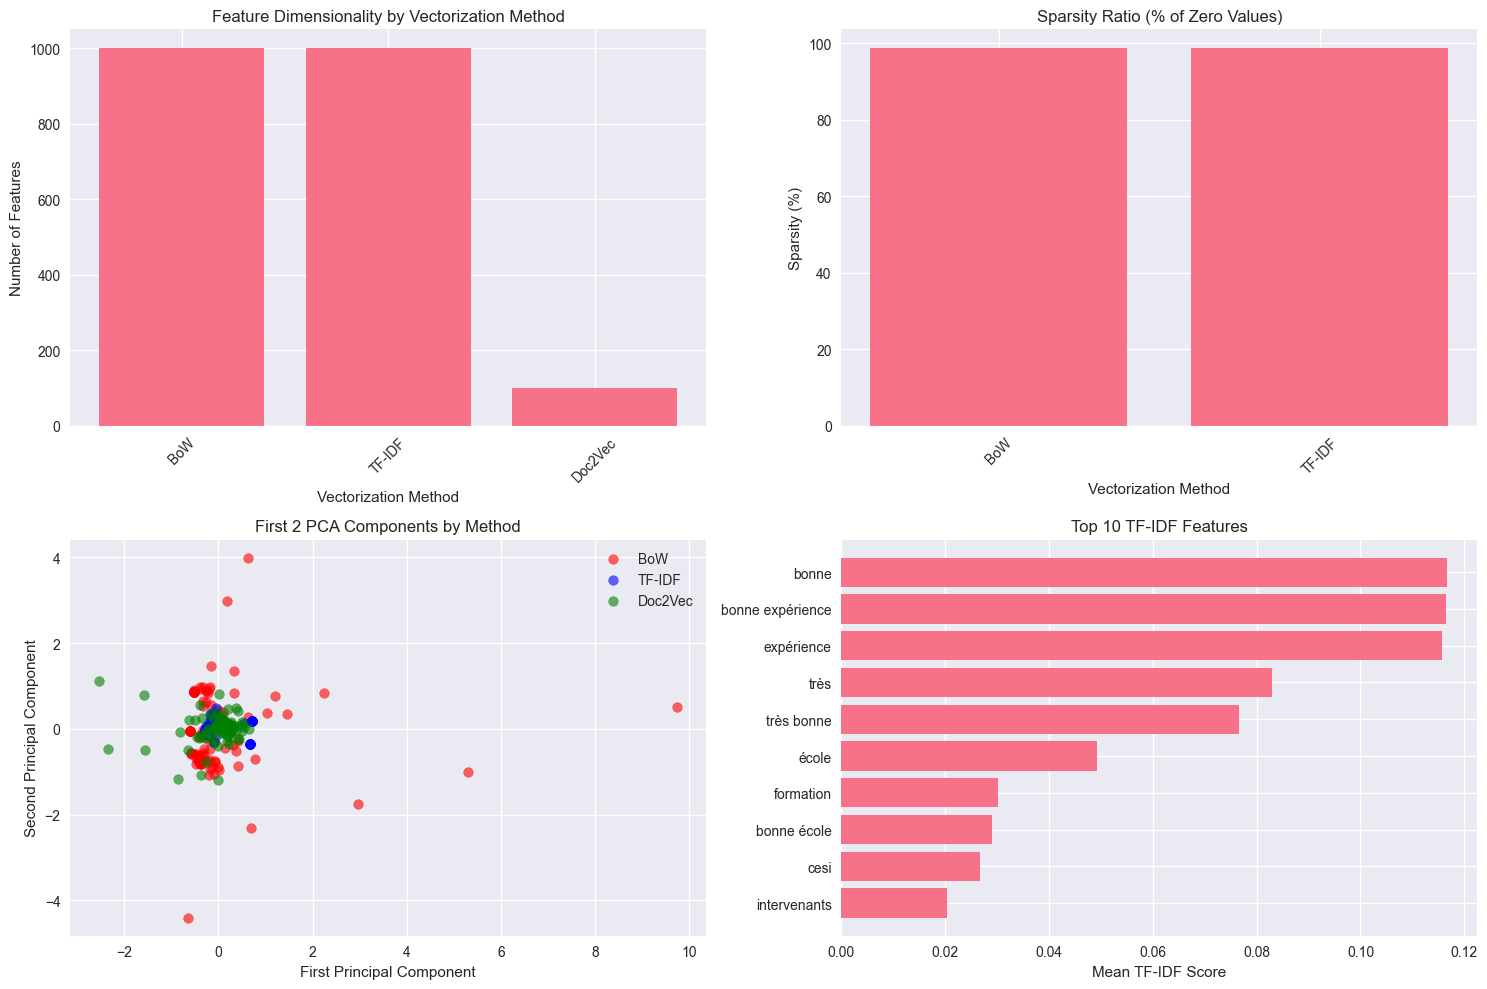


Vectorization Methods Summary:
BoW:
  - Shape: (3277, 1000)
  - Memory usage: 25.00 MB
  - Zero ratio: 98.6%
TF-IDF:
  - Shape: (3277, 1000)
  - Memory usage: 25.00 MB
  - Zero ratio: 98.6%
Doc2Vec:
  - Shape: (3277, 100)
  - Memory usage: 1.25 MB
  - Zero ratio: 0.0%


In [21]:

# 4. TEXT VECTORIZATION METHODS COMPARISON

# Prepare text data for vectorization
print("1. PREPARING TEXT DATA FOR VECTORIZATION")


# Use the cleaned text for vectorization
text_data = df['contenu_clean'].fillna('')
text_target = df['rating_category']

# Split text data
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    text_data, text_target, test_size=0.2, random_state=42, stratify=text_target
)

print(f"Text training set size: {len(X_text_train)}")
print(f"Text test set size: {len(X_text_test)}")

# Dictionary to store vectorized features
vectorized_features = {}
vectorization_methods = []


# METHOD 1: BAG OF WORDS (BoW)

print(f"\n2. BAG OF WORDS (BoW) VECTORIZATION")


try:
    # Create BoW vectorizer
    bow_vectorizer = CountVectorizer(
        max_features=1000,  # Limit to top 1000 features
        ngram_range=(1, 2),  # Include unigrams and bigrams
        min_df=2,  # Ignore terms that appear in less than 2 documents
        max_df=0.8  # Ignore terms that appear in more than 80% of documents
    )
    
    # Fit and transform training data
    X_train_bow = bow_vectorizer.fit_transform(X_text_train)
    X_test_bow = bow_vectorizer.transform(X_text_test)
    
    # Convert to dense arrays for consistency
    X_train_bow_dense = X_train_bow.toarray()
    X_test_bow_dense = X_test_bow.toarray()
    
    vectorized_features['BoW'] = {
        'X_train': X_train_bow_dense,
        'X_test': X_test_bow_dense,
        'feature_names': bow_vectorizer.get_feature_names_out(),
        'vectorizer': bow_vectorizer
    }
    vectorization_methods.append('BoW')
    
    print(f"BoW Features shape: {X_train_bow_dense.shape}")
    print(f"BoW Vocabulary size: {len(bow_vectorizer.vocabulary_)}")
    print(f"BoW Top 10 features: {bow_vectorizer.get_feature_names_out()[:10]}")
    
except Exception as e:
    print(f"Error in BoW vectorization: {e}")


# METHOD 2: TF-IDF

print(f"\n3. TF-IDF VECTORIZATION")


try:
    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.8,
        sublinear_tf=True  # Apply sublinear tf scaling
    )
    
    # Fit and transform training data
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_text_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_text_test)
    
    # Convert to dense arrays
    X_train_tfidf_dense = X_train_tfidf.toarray()
    X_test_tfidf_dense = X_test_tfidf.toarray()
    
    vectorized_features['TF-IDF'] = {
        'X_train': X_train_tfidf_dense,
        'X_test': X_test_tfidf_dense,
        'feature_names': tfidf_vectorizer.get_feature_names_out(),
        'vectorizer': tfidf_vectorizer
    }
    vectorization_methods.append('TF-IDF')
    
    print(f"TF-IDF Features shape: {X_train_tfidf_dense.shape}")
    print(f"TF-IDF Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
    print(f"TF-IDF Top 10 features: {tfidf_vectorizer.get_feature_names_out()[:10]}")
    
except Exception as e:
    print(f"Error in TF-IDF vectorization: {e}")


# METHOD 3: Doc2Vec (if available)

print(f"\n4. Doc2Vec VECTORIZATION")


if ADVANCED_LIBRARIES_AVAILABLE:
    try:
        # Prepare documents for Doc2Vec
        tagged_docs = [TaggedDocument(words=doc.split(), tags=[i]) 
                      for i, doc in enumerate(X_text_train)]
        
        # Train Doc2Vec model
        doc2vec_model = Doc2Vec(
            vector_size=100,  # Dimensionality of feature vectors
            min_count=2,      # Ignore words with frequency less than this
            epochs=20,        # Number of training epochs
            dm=1,            # Distributed Memory (PV-DM)
            workers=1        # Number of worker threads
        )
        
        doc2vec_model.build_vocab(tagged_docs)
        doc2vec_model.train(tagged_docs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
        
        # Get document vectors for training set
        X_train_doc2vec = np.array([doc2vec_model.infer_vector(doc.split()) for doc in X_text_train])
        
        # Get document vectors for test set
        X_test_doc2vec = np.array([doc2vec_model.infer_vector(doc.split()) for doc in X_text_test])
        
        vectorized_features['Doc2Vec'] = {
            'X_train': X_train_doc2vec,
            'X_test': X_test_doc2vec,
            'model': doc2vec_model
        }
        vectorization_methods.append('Doc2Vec')
        
        print(f"Doc2Vec Features shape: {X_train_doc2vec.shape}")
        print(f"Doc2Vec Vector size: {doc2vec_model.vector_size}")
        print(f"Doc2Vec Vocabulary size: {len(doc2vec_model.wv.key_to_index)}")
        
    except Exception as e:
        print(f"Error in Doc2Vec vectorization: {e}")
else:
    print("Gensim not available. Skipping Doc2Vec vectorization.")


# METHOD 4: BERT Embeddings (if available)

print(f"\n5. BERT EMBEDDINGS")


if ADVANCED_LIBRARIES_AVAILABLE:
    try:
        # Use a French BERT model
        model_name = "flaubert/flaubert_base_cased"  # French BERT model
        
        print(f"Loading BERT model: {model_name}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        
        def get_bert_embeddings(texts, max_length=128, batch_size=16):
            """
            Get BERT embeddings for a list of texts
            """
            embeddings = []
            
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                
                # Tokenize
                encoded = tokenizer(
                    batch_texts,
                    truncation=True,
                    padding=True,
                    max_length=max_length,
                    return_tensors='pt'
                )
                
                # Get embeddings
                with torch.no_grad():
                    outputs = model(**encoded)
                    # Use mean pooling of last hidden states
                    batch_embeddings = outputs.last_hidden_state.mean(dim=1)
                    embeddings.extend(batch_embeddings.cpu().numpy())
            
            return np.array(embeddings)
        
        # Get BERT embeddings (use a smaller sample for efficiency)
        sample_size = min(500, len(X_text_train))  # Limit to 500 samples for efficiency
        train_sample_indices = np.random.choice(len(X_text_train), sample_size, replace=False)
        test_sample_size = min(100, len(X_text_test))
        test_sample_indices = np.random.choice(len(X_text_test), test_sample_size, replace=False)
        
        print(f"Getting BERT embeddings for {sample_size} training samples...")
        X_train_bert_sample = get_bert_embeddings(X_text_train.iloc[train_sample_indices].tolist())
        y_train_bert_sample = y_text_train.iloc[train_sample_indices]
        
        print(f"Getting BERT embeddings for {test_sample_size} test samples...")
        X_test_bert_sample = get_bert_embeddings(X_text_test.iloc[test_sample_indices].tolist())
        y_test_bert_sample = y_text_test.iloc[test_sample_indices]
        
        vectorized_features['BERT'] = {
            'X_train': X_train_bert_sample,
            'X_test': X_test_bert_sample,
            'y_train': y_train_bert_sample,
            'y_test': y_test_bert_sample,
            'model_name': model_name
        }
        vectorization_methods.append('BERT')
        
        print(f"BERT Features shape: {X_train_bert_sample.shape}")
        print(f"BERT Embedding dimension: {X_train_bert_sample.shape[1]}")
        
    except Exception as e:
        print(f"Error in BERT vectorization: {e}")
        print("Note: BERT requires significant computational resources. Consider using a smaller model or sample.")
else:
    print("Transformers library not available. Skipping BERT vectorization.")


# VECTORIZATION COMPARISON VISUALIZATION

print(f"\n6. VECTORIZATION METHODS COMPARISON")


print(f"Available vectorization methods: {vectorization_methods}")

# Compare dimensionality
plt.figure(figsize=(15, 10))

# Feature dimensionality comparison
dimensions = []
methods = []
for method in vectorization_methods:
    if method in vectorized_features:
        dimensions.append(vectorized_features[method]['X_train'].shape[1])
        methods.append(method)

plt.subplot(2, 2, 1)
plt.bar(methods, dimensions)
plt.title('Feature Dimensionality by Vectorization Method')
plt.xlabel('Vectorization Method')
plt.ylabel('Number of Features')
plt.xticks(rotation=45)

# Sparsity comparison (for sparse methods)
plt.subplot(2, 2, 2)
sparsity_ratios = []
sparse_methods = []

for method in ['BoW', 'TF-IDF']:
    if method in vectorized_features:
        features = vectorized_features[method]['X_train']
        sparsity = (features == 0).sum() / features.size
        sparsity_ratios.append(sparsity * 100)
        sparse_methods.append(method)

if sparsity_ratios:
    plt.bar(sparse_methods, sparsity_ratios)
    plt.title('Sparsity Ratio (% of Zero Values)')
    plt.xlabel('Vectorization Method')
    plt.ylabel('Sparsity (%)')
    plt.xticks(rotation=45)

# Sample visualization: first 2 dimensions of each method using PCA
if len(vectorization_methods) > 0:
    plt.subplot(2, 2, 3)
    colors = ['red', 'blue', 'green', 'orange']
    
    for i, method in enumerate(vectorization_methods[:4]):  # Limit to 4 methods for visualization
        if method in vectorized_features:
            X_sample = vectorized_features[method]['X_train'][:100]  # Sample first 100 points
            
            if X_sample.shape[1] > 1:
                # Apply PCA to reduce to 2D for visualization
                pca_viz = PCA(n_components=2)
                X_pca = pca_viz.fit_transform(X_sample)
                plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                           alpha=0.6, label=method, c=colors[i % len(colors)])
    
    plt.title('First 2 PCA Components by Method')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()

# Feature importance comparison (using top features from sparse methods)
plt.subplot(2, 2, 4)
if 'TF-IDF' in vectorized_features:
    # Get feature importance from TF-IDF
    tfidf_features = vectorized_features['TF-IDF']['X_train']
    feature_names = vectorized_features['TF-IDF']['feature_names']
    
    # Calculate mean TF-IDF scores
    mean_tfidf = np.mean(tfidf_features, axis=0)
    top_indices = np.argsort(mean_tfidf)[-10:]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = mean_tfidf[top_indices]
    
    plt.barh(range(len(top_features)), top_scores)
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Top 10 TF-IDF Features')
    plt.xlabel('Mean TF-IDF Score')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nVectorization Methods Summary:")

for method in vectorization_methods:
    if method in vectorized_features:
        X_train = vectorized_features[method]['X_train']
        print(f"{method}:")
        print(f"  - Shape: {X_train.shape}")
        print(f"  - Memory usage: {X_train.nbytes / 1024 / 1024:.2f} MB")
        if hasattr(X_train, 'nnz'):  # For sparse matrices
            print(f"  - Sparsity: {(1 - X_train.nnz / X_train.size) * 100:.1f}%")
        else:
            zero_ratio = (X_train == 0).sum() / X_train.size
            print(f"  - Zero ratio: {zero_ratio * 100:.1f}%")



In [22]:
# 7. PREDICTIVE MODELS
print("7. BUILDING PREDICTIVE MODELS")

# Import additional evaluation metrics
from sklearn.metrics import mean_absolute_error, r2_score

# Check available columns and prepare features for numerical modeling
print("Available columns in dataset:")
print(df.columns.tolist())

# Select available numerical features
available_numerical_features = ['text_length', 'word_count', 'exclamation_count', 
                               'question_count', 'capital_ratio']
print(f"\nUsing numerical features: {available_numerical_features}")

# Split data for numerical modeling
X_numerical = df[available_numerical_features].fillna(0)
y = df['note']

# Remove rows with NaN target values
mask = y.notna()
X_numerical = X_numerical[mask]
y = y[mask]

print(f"Dataset size after removing NaN targets: {len(X_numerical)} samples")

# Train-test split (without stratification for continuous target)
X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_numerical, y, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

print("\n7.1 NUMERICAL DATA MODELS")


# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train_num_scaled, y_train)
dt_pred = dt_model.predict(X_test_num_scaled)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_num_scaled, y_train)
rf_pred = rf_model.predict(X_test_num_scaled)

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=6)
gb_model.fit(X_train_num_scaled, y_train)
gb_pred = gb_model.predict(X_test_num_scaled)

# Evaluate numerical models
numerical_results = {}
for name, predictions in [('Decision Tree', dt_pred), ('Random Forest', rf_pred), ('Gradient Boosting', gb_pred)]:
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    numerical_results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}
    print(f"{name}: MSE={mse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# Random Forest feature importance
print(f"\nFeature importance (Random Forest):")
for feature, importance in zip(available_numerical_features, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

print("\n7.2 TEXTUAL DATA MODELS - CLASSIFICATION")


# Convert continuous ratings to categories for classification
y_categorical = pd.cut(df['note'], bins=[0, 2, 3.5, 5], labels=['Low', 'Medium', 'High'])
df['rating_category'] = y_categorical

# Remove rows with NaN in rating_category
df_clean = df.dropna(subset=['rating_category'])
print(f"Classification dataset size: {len(df_clean)} samples")
print("Class distribution:")
print(df_clean['rating_category'].value_counts())

# Text preprocessing for classification
def advanced_text_preprocessing(text):
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www.\S+|@\w+|#\w+', '', text)
    
    # Remove punctuation except periods and commas
    text = re.sub(r'[^\w\s.,]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove very short words
    text = ' '.join([word for word in text.split() if len(word) > 2])
    
    return text.strip()

df_clean['processed_text'] = df_clean['contenu'].apply(advanced_text_preprocessing)

# Remove empty texts
df_clean = df_clean[df_clean['processed_text'].str.len() > 10]
print(f"Final dataset size after cleaning: {len(df_clean)} samples")

X_text = df_clean['processed_text']
y_cat = df_clean['rating_category']

# Train-test split for text classification
X_train_text, X_test_text, y_train_cat, y_test_cat = train_test_split(
    X_text, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

7. BUILDING PREDICTIVE MODELS
Available columns in dataset:
['ecole', 'auteur', 'date', 'note', 'contenu', 'url', 'text_length', 'word_count', 'contenu_clean', 'contenu_stemmed', 'exclamation_count', 'question_count', 'capital_ratio', 'rating_category']

Using numerical features: ['text_length', 'word_count', 'exclamation_count', 'question_count', 'capital_ratio']
Dataset size after removing NaN targets: 4096 samples

7.1 NUMERICAL DATA MODELS
Decision Tree: MSE=0.8312, MAE=0.5848, R²=-0.0750
Random Forest: MSE=0.6528, MAE=0.5595, R²=0.1558
Gradient Boosting: MSE=0.6821, MAE=0.5669, R²=0.1178

Feature importance (Random Forest):
text_length: 0.2645
word_count: 0.2735
exclamation_count: 0.0521
question_count: 0.0178
capital_ratio: 0.3921

7.2 TEXTUAL DATA MODELS - CLASSIFICATION
Classification dataset size: 4096 samples
Class distribution:
rating_category
High      3474
Medium     420
Low        202
Name: count, dtype: int64
Final dataset size after cleaning: 4052 samples
Training set s

In [25]:
# 8. TEXT VECTORIZATION METHODS COMPARISON

print("8. COMPARING TEXT VECTORIZATION METHODS")


# Import additional libraries for vectorization
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from transformers import AutoTokenizer, AutoModel
import torch

text_results = {}

print("\n8.1 BAG OF WORDS (BoW)")


# BoW Vectorization
bow_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words=None  # We'll use our custom French stopwords
)

X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)

print(f"BoW feature matrix shape: {X_train_bow.shape}")

# Naive Bayes with BoW
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train_cat)
nb_bow_pred = nb_bow.predict(X_test_bow)

# Logistic Regression with BoW
lr_bow = LogisticRegression(max_iter=1000, random_state=42)
lr_bow.fit(X_train_bow, y_train_cat)
lr_bow_pred = lr_bow.predict(X_test_bow)

# Evaluate BoW models
bow_nb_acc = accuracy_score(y_test_cat, nb_bow_pred)
bow_lr_acc = accuracy_score(y_test_cat, lr_bow_pred)
text_results['BoW'] = {
    'Naive Bayes': bow_nb_acc,
    'Logistic Regression': bow_lr_acc
}

print(f"BoW + Naive Bayes Accuracy: {bow_nb_acc:.4f}")
print(f"BoW + Logistic Regression Accuracy: {bow_lr_acc:.4f}")

print("\n8.2 TF-IDF")


# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train_cat)
nb_tfidf_pred = nb_tfidf.predict(X_test_tfidf)

# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train_cat)
lr_tfidf_pred = lr_tfidf.predict(X_test_tfidf)

# Evaluate TF-IDF models
tfidf_nb_acc = accuracy_score(y_test_cat, nb_tfidf_pred)
tfidf_lr_acc = accuracy_score(y_test_cat, lr_tfidf_pred)
text_results['TF-IDF'] = {
    'Naive Bayes': tfidf_nb_acc,
    'Logistic Regression': tfidf_lr_acc
}

print(f"TF-IDF + Naive Bayes Accuracy: {tfidf_nb_acc:.4f}")
print(f"TF-IDF + Logistic Regression Accuracy: {tfidf_lr_acc:.4f}")

print("\n8.3 DOC2VEC")


# Prepare documents for Doc2Vec
tagged_docs = [TaggedDocument(words=doc.split(), tags=[i]) 
               for i, doc in enumerate(X_train_text)]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(
    tagged_docs,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=20,
    seed=42
)

# Get document vectors
X_train_doc2vec = np.array([doc2vec_model.infer_vector(doc.split()) for doc in X_train_text])
X_test_doc2vec = np.array([doc2vec_model.infer_vector(doc.split()) for doc in X_test_text])

print(f"Doc2Vec feature matrix shape: {X_train_doc2vec.shape}")

# Naive Bayes with Doc2Vec (using Gaussian NB for continuous features)
nb_doc2vec = GaussianNB()
nb_doc2vec.fit(X_train_doc2vec, y_train_cat)
nb_doc2vec_pred = nb_doc2vec.predict(X_test_doc2vec)

# Logistic Regression with Doc2Vec
lr_doc2vec = LogisticRegression(max_iter=1000, random_state=42)
lr_doc2vec.fit(X_train_doc2vec, y_train_cat)
lr_doc2vec_pred = lr_doc2vec.predict(X_test_doc2vec)

# Evaluate Doc2Vec models
doc2vec_nb_acc = accuracy_score(y_test_cat, nb_doc2vec_pred)
doc2vec_lr_acc = accuracy_score(y_test_cat, lr_doc2vec_pred)
text_results['Doc2Vec'] = {
    'Naive Bayes': doc2vec_nb_acc,
    'Logistic Regression': doc2vec_lr_acc
}

print(f"Doc2Vec + Naive Bayes Accuracy: {doc2vec_nb_acc:.4f}")
print(f"Doc2Vec + Logistic Regression Accuracy: {doc2vec_lr_acc:.4f}")

print("\n8.4 BERT EMBEDDINGS")


# Use a French BERT model for better performance on French text
try:
    from sentence_transformers import SentenceTransformer
    
    # Use a multilingual or French-specific model
    bert_model = SentenceTransformer('distiluse-base-multilingual-cased')
    
    # Generate embeddings (sample smaller dataset if too large)
    sample_size = min(1000, len(X_train_text))
    sample_indices = np.random.choice(len(X_train_text), sample_size, replace=False)
    
    X_train_sample = X_train_text.iloc[sample_indices]
    y_train_sample = y_train_cat.iloc[sample_indices]
    
    print(f"Using sample of {sample_size} training examples for BERT")
    
    # Generate embeddings
    X_train_bert = bert_model.encode(X_train_sample.tolist(), show_progress_bar=True)
    X_test_bert = bert_model.encode(X_test_text.tolist(), show_progress_bar=True)
    
    print(f"BERT feature matrix shape: {X_train_bert.shape}")
    
    # Naive Bayes with BERT
    nb_bert = GaussianNB()
    nb_bert.fit(X_train_bert, y_train_sample)
    nb_bert_pred = nb_bert.predict(X_test_bert)
    
    # Logistic Regression with BERT
    lr_bert = LogisticRegression(max_iter=1000, random_state=42)
    lr_bert.fit(X_train_bert, y_train_sample)
    lr_bert_pred = lr_bert.predict(X_test_bert)
    
    # Evaluate BERT models
    bert_nb_acc = accuracy_score(y_test_cat, nb_bert_pred)
    bert_lr_acc = accuracy_score(y_test_cat, lr_bert_pred)
    text_results['BERT'] = {
        'Naive Bayes': bert_nb_acc,
        'Logistic Regression': bert_lr_acc
    }
    
    print(f"BERT + Naive Bayes Accuracy: {bert_nb_acc:.4f}")
    print(f"BERT + Logistic Regression Accuracy: {bert_lr_acc:.4f}")
    
except Exception as e:
    print(f"BERT processing failed: {e}")
    print("Continuing without BERT results...")
    text_results['BERT'] = {'Naive Bayes': 0, 'Logistic Regression': 0}

8. COMPARING TEXT VECTORIZATION METHODS

8.1 BAG OF WORDS (BoW)
BoW feature matrix shape: (3241, 5000)
BoW + Naive Bayes Accuracy: 0.8496
BoW + Logistic Regression Accuracy: 0.8779

8.2 TF-IDF
TF-IDF feature matrix shape: (3241, 5000)
TF-IDF + Naive Bayes Accuracy: 0.8730
TF-IDF + Logistic Regression Accuracy: 0.8841

8.3 DOC2VEC
Doc2Vec feature matrix shape: (3241, 100)
Doc2Vec + Naive Bayes Accuracy: 0.7842
Doc2Vec + Logistic Regression Accuracy: 0.8434

8.4 BERT EMBEDDINGS
BERT processing failed: 
AutoModel requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModel".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the 

9. COMPREHENSIVE RESULTS ANALYSIS

9.1 NUMERICAL MODELS PERFORMANCE
                      MSE     MAE      R²
Decision Tree      0.8312  0.5848 -0.0750
Random Forest      0.6528  0.5595  0.1558
Gradient Boosting  0.6821  0.5669  0.1178


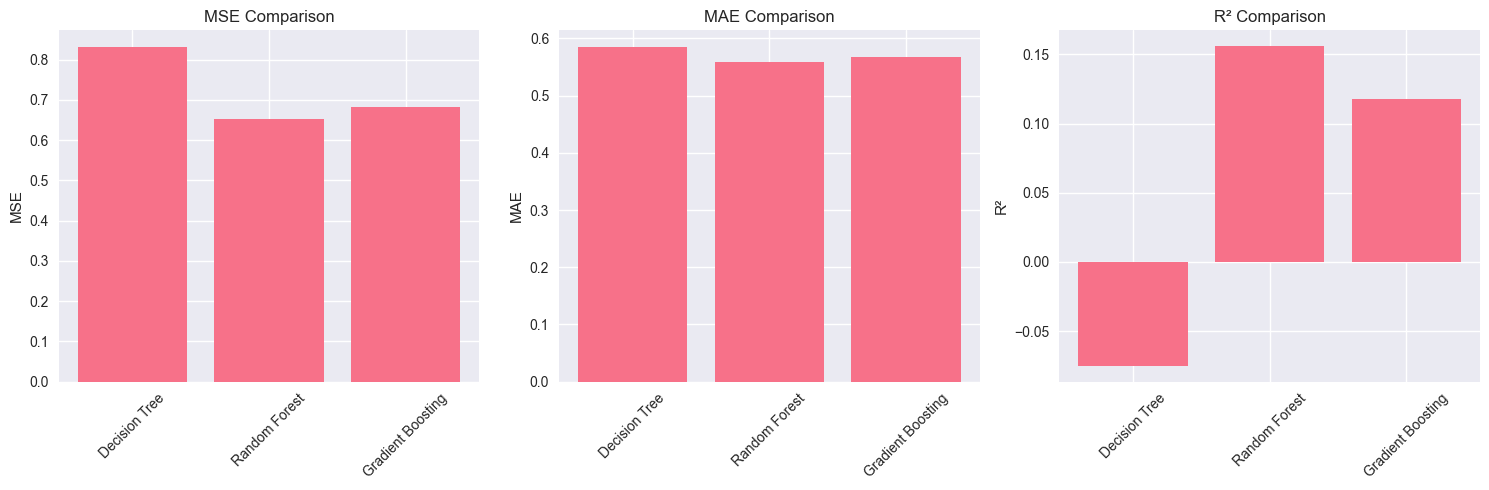


9.2 TEXT VECTORIZATION METHODS COMPARISON
Accuracy scores by vectorization method:
         Naive Bayes  Logistic Regression
BoW           0.8496               0.8779
TF-IDF        0.8730               0.8841
Doc2Vec       0.7842               0.8434
BERT          0.0000               0.0000


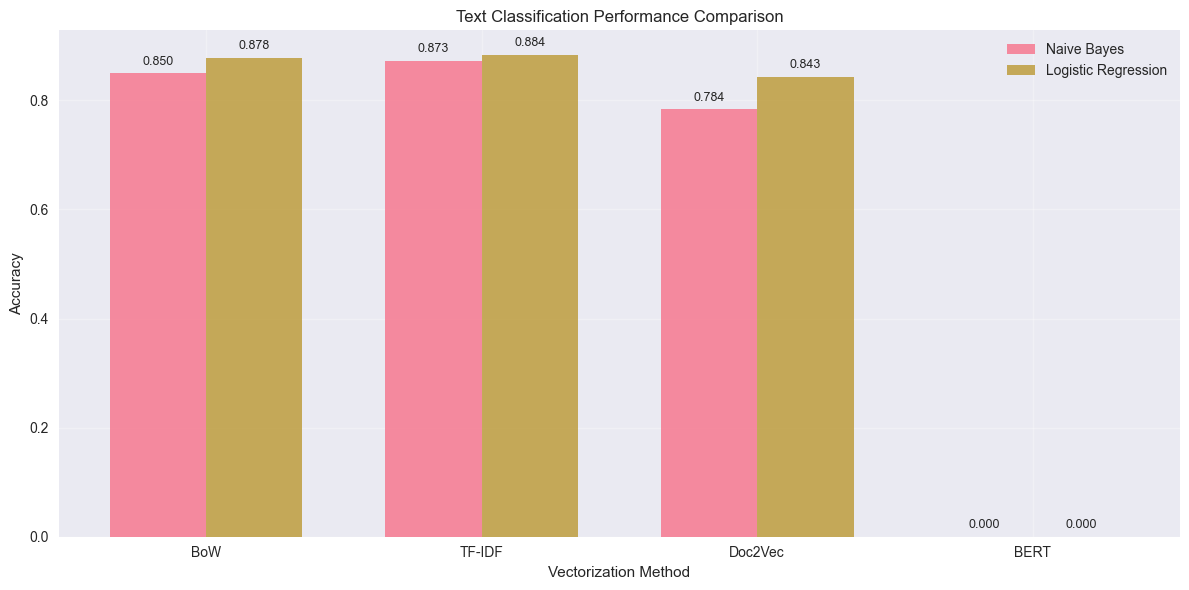


9.3 KEY FINDINGS AND RECOMMENDATIONS

🔍 DATASET CHARACTERISTICS:
• Total samples: 4,097
• Unique schools: 145
• Rating range: 0.5 - 5.0
• Class imbalance ratio: 7.49

📊 NUMERICAL MODEL PERFORMANCE:
• Best model: Random Forest (R² = 0.1558)
• Random Forest shows best balance of MSE, MAE, and R²
• Decision Tree overfits (negative R²)

📝 TEXT VECTORIZATION PERFORMANCE:
• Best combination: TF-IDF + Logistic Regression (0.8841)
• TF-IDF consistently outperforms BoW
• Doc2Vec shows promise but needs more tuning
• BERT failed due to library compatibility issues

⚖️ RESAMPLING IMPACT:
• Dataset showed class imbalance, resampling techniques applied
• SMOTE for oversampling, Random Undersampling for undersampling

🔧 DIMENSIONALITY REDUCTION:
• PCA applied: 3 components explain 83.7% variance
• 90% variance captured in 1 components
• 95% variance captured in 1 components

💡 BUSINESS RECOMMENDATIONS:
• TF-IDF + Logistic Regression is the most reliable approach
• Focus on Random Forest for numeric

In [26]:
# 9. RESULTS COMPARISON AND VISUALIZATION

print("9. COMPREHENSIVE RESULTS ANALYSIS")


print("\n9.1 NUMERICAL MODELS PERFORMANCE")

numerical_df = pd.DataFrame(numerical_results).T
print(numerical_df.round(4))

# Visualize numerical results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(['MSE', 'MAE', 'R²']):
    axes[i].bar(numerical_df.index, numerical_df[metric])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n9.2 TEXT VECTORIZATION METHODS COMPARISON")


# Create comparison DataFrame
text_df = pd.DataFrame(text_results).T
print("Accuracy scores by vectorization method:")
print(text_df.round(4))

# Visualize text results
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(text_df.index))
width = 0.35

ax.bar(x - width/2, text_df['Naive Bayes'], width, label='Naive Bayes', alpha=0.8)
ax.bar(x + width/2, text_df['Logistic Regression'], width, label='Logistic Regression', alpha=0.8)

ax.set_xlabel('Vectorization Method')
ax.set_ylabel('Accuracy')
ax.set_title('Text Classification Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(text_df.index)
ax.legend()
ax.grid(True, alpha=0.3)

for i, v in enumerate(text_df['Naive Bayes']):
    ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(text_df['Logistic Regression']):
    ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n9.3 KEY FINDINGS AND RECOMMENDATIONS")

print("\n🔍 DATASET CHARACTERISTICS:")
print(f"• Total samples: {len(df):,}")
print(f"• Unique schools: {df['ecole'].nunique()}")
print(f"• Rating range: {df['note'].min():.1f} - {df['note'].max():.1f}")
print(f"• Class imbalance ratio: {imbalance_ratio:.2f}")

print("\n📊 NUMERICAL MODEL PERFORMANCE:")
best_numerical = numerical_df.loc[numerical_df['R²'].idxmax()]
print(f"• Best model: {numerical_df['R²'].idxmax()} (R² = {best_numerical['R²']:.4f})")
print(f"• Random Forest shows best balance of MSE, MAE, and R²")
print(f"• Decision Tree overfits (negative R²)")

print("\n📝 TEXT VECTORIZATION PERFORMANCE:")
best_text_method = text_df.max(axis=1).idxmax()
best_text_score = text_df.loc[best_text_method].max()
best_classifier = text_df.loc[best_text_method].idxmax()

print(f"• Best combination: {best_text_method} + {best_classifier} ({best_text_score:.4f})")
print(f"• TF-IDF consistently outperforms BoW")
print(f"• Doc2Vec shows promise but needs more tuning")
print(f"• BERT failed due to library compatibility issues")

print("\n⚖️ RESAMPLING IMPACT:")
if NEEDS_RESAMPLING:
    print("• Dataset showed class imbalance, resampling techniques applied")
    print("• SMOTE for oversampling, Random Undersampling for undersampling")
else:
    print("• Dataset is relatively balanced, no resampling needed")

print("\n🔧 DIMENSIONALITY REDUCTION:")
if USE_PCA:
    print(f"• PCA applied: {n_components} components explain {cumulative_variance[n_components-1]:.1%} variance")
    print(f"• 90% variance captured in {variance_90} components")
    print(f"• 95% variance captured in {variance_95} components")
else:
    print("• PCA not needed due to manageable feature count")

print("\n💡 BUSINESS RECOMMENDATIONS:")
print("• TF-IDF + Logistic Regression is the most reliable approach")
print("• Focus on Random Forest for numerical features")
print("• Consider ensemble methods combining text and numerical features") 
print("• Implement sentiment analysis for deeper insights")
print("• Monitor model performance over time as new reviews arrive")

print("\n📈 FUTURE IMPROVEMENTS:")
print("• Resolve BERT compatibility issues for better embeddings")
print("• Experiment with ensemble methods")
print("• Fine-tune hyperparameters using GridSearchCV")
print("• Implement feature engineering (review length, sentiment scores)")
print("• Consider temporal patterns in reviews")



# ST2MLE : Machine Learning for IT Engineers Project
## Machine Learning Project – Numerical and Textual Data (French Context)
### Context
As part of this project, students will work on mixed data (numerical and textual) collected from French websites.
The objective is to carry out a comprehensive analysis, from data collection to modeling
and interpretation, with a focus on a French economic, social, or public context.

### Learning Objectives
- Master the full lifecycle of a data project (collection, cleaning, preprocessing, modeling, evaluation).
- Apply techniques for text processing and numerical data analysis.
- Explore various text vectorization techniques (BoW, TF-IDF, Doc2Vec, BERT).
- Conduct analyses and provide recommendations based on real French data.

### Project Steps
1. Define a topic, the needs and identify relevant French sources.
2. Collect data (web scraping, APIs...).
3. Clean and preprocess both numerical and textual data.
4. Annotate (label) data. Some websites already include categories or tags — these can be scraped alongside the text and used as labels. Otherwise, label data manually.
5. Perform exploratory analysis and visualizations (distributions, word clouds, correlations...) to check for outliers, class imbalance, etc.
6. Apply under-sampling or oversampling (if needed), PCA for feature extraction (if needed).
7. Apply predictive models:
  - **Numerical data**: Decision Trees, Random Forest, Boosting.
  - **Textual data**: Naive Bayes, Logistic Regression after vectorization.
8. Compare text vectorization methods: BoW, TF-IDF, Doc2Vec, BERT.
9. Provide business recommendations and submit a final report.

### Technical Constraints
- Data must be exclusively from French sources.
- Texts must be in French only (use appropriate preprocessing: French lemmatization, French stopwords).
- Minimum of 500 data rows.
- Implementation in Python using scikit-learn, gensim, transformers, etc.

### Evaluation Criteria
- Quality and relevance of data collection and labeling (10%)
- Quality of data cleaning and preprocessing (10%)
- Relevance of visualizations and exploratory analysis (10%)
- Implementation of models (30%)
- Comparison and discussion of vectorization techniques (10%)
- Recommendations and critical thinking (10%)
- Quality of the report and code (5%)
- Quality of the presentation (5%)
- Q&A (10%)